In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import tqdm
import numpy as np

In [2]:
from matplotlib import pyplot as plt

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [4]:
class MyDataset(Dataset):
    def __init__(self, files, labels, mode, k):
        super().__init__()
        self.files = list(files * k)
        self.labels = torch.tensor(labels * k, dtype=torch.float32)
        self.mode = mode
        self.len_ = len(self.files)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        train_transforms = transforms.Compose([
            #transforms.RandomCrop((30, 30)),
            transforms.RandomResizedCrop((30, 30), (0.8, 1.1))
        ])

        test_transforms = transforms.Compose([
            transforms.CenterCrop((30, 30))
        ])
        x = self.load_sample(self.files[index])
        
        if self.mode == 'test':
            x = test_transforms(x)
        else:
            x = train_transforms(x)
        x = transform(x)
        y = self.labels[index]
        return x, y

In [5]:
files = []
labels = []
for i in range(14):
    files.append(f'dataset/{i}/img.png')
    label = [0 for j in range(14)]
    label[i] = 1
    labels.append(label)
train_dataset = MyDataset(files, labels, 'train', 400)
test_dataset = MyDataset(files, labels, 'test', 20)
train_loader = DataLoader(train_dataset, len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, len(test_dataset), shuffle=True)

In [6]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Flatten(),
    nn.Linear(16 * 81, 128),
    nn.ReLU(),
    nn.Linear(128, 80),
    nn.ReLU(),
    nn.Linear(80, 14),
    nn.Softmax(dim=1)
).to(device)
"""
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(30 * 30, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 14),
    nn.Softmax(dim=1)
).to(device)"""

'\nmodel = nn.Sequential(\n    nn.Flatten(),\n    nn.Linear(30 * 30, 128),\n    nn.ReLU(),\n    nn.Linear(128, 64),\n    nn.ReLU(),\n    nn.Linear(64, 14),\n    nn.Softmax(dim=1)\n).to(device)'

In [7]:
#model = torch.load('model/v3').to(device)

In [22]:
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

In [16]:

losses_tr = []
losses_te = []

In [28]:
for x_train, y_train in train_loader:
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    break
for x_test, y_test in test_loader:
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    break
for epoch in tqdm.tqdm(range(600)):
    optim.zero_grad()
    model.train()
    #for x, y in train_loader:
        #print(x.shape)
    #x = x.to(device)
    preds = model.forward(x_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optim.step()
    model.eval()
    torch.no_grad()
    preds =  model.forward(x_test)
    loss_test = criterion(preds, y_test)
    if epoch % 30 == 0:
        print(float(loss.detach()), float(loss_test.detach()))
    losses_tr.append(float(loss.detach()))
    losses_te.append(float(loss_test.detach()))

  0%|          | 2/600 [00:00<00:44, 13.37it/s]

0.0003641020739451051 1.970412085938733e-05


  5%|▌         | 32/600 [00:02<00:41, 13.58it/s]

0.00017527485033497214 7.941197509353515e-06


 10%|█         | 62/600 [00:04<00:39, 13.49it/s]

0.00013690149353351444 9.545492503093556e-06


 15%|█▌        | 92/600 [00:06<00:39, 12.98it/s]

0.00010721362195909023 1.2570008948387112e-05


 20%|██        | 122/600 [00:09<00:35, 13.35it/s]

8.08697150205262e-05 1.6964031601673923e-05


 25%|██▌       | 152/600 [00:11<00:33, 13.50it/s]

6.518440932268277e-05 1.7977388779399917e-05


 30%|███       | 182/600 [00:13<00:31, 13.15it/s]

5.5659242207184434e-05 1.5467163393623196e-05


 35%|███▌      | 212/600 [00:15<00:28, 13.50it/s]

4.8896847147261724e-05 1.2713462638203055e-05


 40%|████      | 242/600 [00:18<00:26, 13.37it/s]

4.374516720417887e-05 1.0662631211744156e-05


 45%|████▌     | 272/600 [00:20<00:23, 13.85it/s]

3.96366449422203e-05 9.105609024118166e-06


 50%|█████     | 302/600 [00:22<00:21, 13.85it/s]

3.62380851584021e-05 7.927233127702493e-06


 55%|█████▌    | 332/600 [00:24<00:19, 13.63it/s]

3.337075759191066e-05 7.001455742283724e-06


 60%|██████    | 362/600 [00:26<00:17, 13.53it/s]

3.0902559956302866e-05 6.26860082775238e-06


 65%|██████▌   | 392/600 [00:29<00:15, 13.68it/s]

2.8736852982547134e-05 5.676927230524598e-06


 70%|███████   | 422/600 [00:31<00:12, 13.75it/s]

2.6819425329449587e-05 5.167404196981806e-06


 75%|███████▌  | 452/600 [00:33<00:10, 13.82it/s]

2.510730701033026e-05 4.7278599595301785e-06


 80%|████████  | 482/600 [00:35<00:08, 13.20it/s]

2.3569115001009777e-05 4.351290954218712e-06


 85%|████████▌ | 512/600 [00:37<00:06, 13.58it/s]

2.2176345737534575e-05 4.019746938865865e-06


 90%|█████████ | 542/600 [00:40<00:04, 13.86it/s]

2.0906329154968262e-05 3.7256208997860085e-06


 95%|█████████▌| 572/600 [00:42<00:02, 13.88it/s]

1.9745028112083673e-05 3.4451866213203175e-06


100%|██████████| 600/600 [00:44<00:00, 13.53it/s]


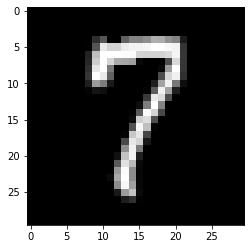

In [37]:
plt.imshow(np.squeeze(np.rollaxis(x_train[30].cpu().numpy(), 0, 3)), cmap='gray')

In [30]:
x_train.shape

torch.Size([5600, 1, 30, 30])

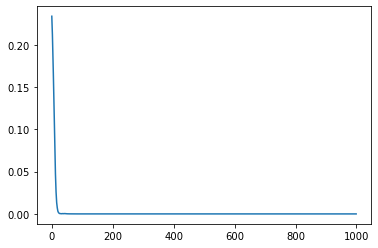

In [33]:
plt.plot(losses_te)
plt.show()

In [34]:
torch.save(model, 'model/v3')